# Dengue Cases in Sri Lanka

In [ ]:
!pip install mplcyberpunk

In [ ]:
# Install the DagsHub python client
!pip install -q dagshub


## 💾 The Data


| Column Name | Description | Data Type | Notes |
|-------------|-------------|-----------|-------|
| `District` | Administrative district in Sri Lanka | String | Key geographic identifier |
| `Number_of_Cases` | Count of dengue cases reported | Integer | Target variable for analysis |
| `Week_Start_Date` | Starting date of the reported week | Date | Temporal reference point |
| `Month` | Month of the year | Integer | Extracted from Week_Start_Date |
| `Year` | Year of the record | Integer | Extracted from Week_Start_Date |
| `Week` | Week number within the year | Integer | Allows for weekly trend analysis |
| `Week_End_Date` | Ending date of the reported week | Date | Complements Week_Start_Date |
| `Avg Max Temp (°C)` | Average maximum temperature | Float | Important climatic factor |
| `Avg Min Temp (°C)` | Average minimum temperature | Float | Important climatic factor |
| `Avg Apparent Max Temp (°C)` | Average maximum "feels like" temperature | Float | Accounts for humidity |
| `Avg Apparent Min Temp (°C)` | Average minimum "feels like" temperature | Float | Accounts for humidity |
| `Total Precipitation (mm)` | Total rainfall and other forms of precipitation | Float | Critical for mosquito breeding |
| `Total Rain (mm)` | Total rainfall | Float | Subset of Total Precipitation |
| `Avg Wind Speed (km/h)` | Average wind speed | Float | Can affect mosquito activity |
| `Max Wind Gusts (km/h)` | Maximum wind gust speed | Float | Extreme weather indicator |
| `Weather Code` | Numeric code representing weather conditions | Integer | Needs a reference guide |
| `Avg Daylight Duration (hours)` | Average length of daylight | Float | Affects mosquito activity periods |
| `Avg Sunrise Time` | Average time of sunrise | Integer | Indicates start of daily cycle |
| `Avg Sunset Time` | Average time of sunset | Integer | Indicates end of daily cycle |

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.patches as mpatches
from matplotlib import cm
from pylab import rcParams
import mplcyberpunk
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use("cyberpunk")

warnings.filterwarnings('ignore')

#### Functions needed

In [ ]:
def is_subplot_unused(ax):
    return not ax.has_data()

def boxplots(df:pd.DataFrame, cols : list, title:str, row_sub:int, col_sub:int):
    num_colors = row_sub * col_sub
    cmap = cm.get_cmap('tab20', num_colors)
    colors = [cmap(i) for i in range(num_colors)]

    figure, axis = plt.subplots(row_sub, col_sub, figsize=(15,8), constrained_layout=True)

    for column, ax, color in zip(cols, axis.ravel(), colors):
        color_with_alpha = list(color)
        color_with_alpha[3] = 0.5  # Set alpha to 0.5
        bplot = ax.boxplot(df[column], vert=False, patch_artist=True, boxprops=dict(facecolor=color_with_alpha, color=color), capprops=dict(color=color),
                        whiskerprops=dict(color=color), flierprops=dict(color=color, markeredgecolor=color), medianprops=dict(color=color))
        ax.set_title(f"\n{column.upper()}", size=15, color=color)
        mplcyberpunk.make_lines_glow(ax, n_glow_lines=20)
        if is_subplot_unused(ax):
           plt.delaxes(ax)

    figure.suptitle(title, fontsize=25,y=1.05)

    plt.show()

def histplots(df:pd.DataFrame, cols : list, title:str, row_sub:int, col_sub:int):
    num_colors = row_sub * col_sub
    cmap = cm.get_cmap('tab20', num_colors)
    colors = [cmap(i) for i in range(num_colors)]

    figure, axis = plt.subplots(row_sub, col_sub, figsize=(15,8), constrained_layout=True)

    for column, ax, color in zip(cols, axis.ravel(), colors):
        color_with_alpha = list(color)
        color_with_alpha[3] = 0.5  # Set alpha to 0.5
        ax.hist(data =df, x=column, bins=50, color=color)
        ax.set_title(f"\n{column.upper()}", size=15, color=color)
        mplcyberpunk.make_lines_glow(ax, n_glow_lines=20)
        if is_subplot_unused(ax):
          plt.delaxes(ax)

    figure.suptitle(title, fontsize=25,y=1.05)

    plt.show()

def describeplot(df: pd.DataFrame, cols : list, title:str):
    summary = df[cols].describe().drop(index='count')
    plt.figure(figsize=(15, 8))
    sns.heatmap(summary, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(title, fontsize=20,y=1.05)
    plt.xlabel('Features',size=15)
    plt.ylabel('Statistics', size=15)
    plt.show()

def bar_plot(df:pd.DataFrame,x_axes:str,y_axes:str,ax:plt.Axes,x_label:str,y_label:str,title:str, num_color : int):
    sns.barplot(data = df, x=x_axes,y=y_axes, ax=ax, palette=colors[: num_color])
    ax.set_xlabel(x_label,fontsize=15,labelpad=10, color="white")
    ax.set_ylabel(y_label, fontsize=15,labelpad=10, color="white")
    ax.set_title(title, fontsize=20, y=1.05, color="white",fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, color="white", fontsize = 13)
    ax.set_yticklabels(ax.get_yticklabels(), color="white", fontsize = 13)
    ax.grid(color='#2A3459')
    ax.set_facecolor("#212946")

def line_plot(df:pd.DataFrame,x_axes:str,y_axes:str,ax:plt.Axes,x_label:str,y_label:str,title:str, label : str):
    sns.lineplot(data = df, x=x_axes,y=y_axes, ax=ax, label = label)
    ax.set_xlabel(x_label,fontsize=15,labelpad=10, color="white")
    ax.set_ylabel(y_label, fontsize=15,labelpad=10, color="white")
    ax.set_title(title, fontsize=20, y=1.05, color="white",fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, color="white", fontsize = 13)
    ax.set_yticklabels(ax.get_yticklabels(), color="white", fontsize = 13)
    ax.grid(color='#2A3459')
    ax.set_facecolor("#212946")
    sns.despine(left=True, bottom=True)

def scatter_plot(df:pd.DataFrame,x_axes:str,y_axes:str,ax:plt.Axes,color:str,x_label:str,y_label:str,title:str, label:str):
    sns.scatterplot(data = df, x=x_axes,y=y_axes, ax=ax,color=color, label =label)
    ax.set_xlabel(x_label,fontsize=15,labelpad=10, color="white")
    ax.set_ylabel(y_label, fontsize=15,labelpad=10, color="white")
    ax.set_title(title, fontsize=20, y=1.05, color="white",fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), color="white", fontsize=13)
    ax.set_yticklabels(ax.get_yticklabels(), color="white", fontsize=13)
    ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5),fontsize=8, facecolor='#212946', labelcolor='white')
    ax.grid(color='#2A3459')
    ax.set_facecolor("#212946")

def pivot_plot (df: pd.DataFrame, title : str, x_label:str, y_label: str, ax :plt.Axes):
    sns.heatmap(df, annot=True, cmap='YlOrRd', ax=ax, fmt = ".2f")
    ax.set_xlabel(x_label,fontsize=15,labelpad=10, color="white")
    ax.set_ylabel(y_label, fontsize=15,labelpad=10, color="white")
    ax.set_title(title, fontsize=20, y=1.05, color="white",fontweight='bold')
    ax.set_xticklabels(ax.get_xticklabels(), color="white", fontsize = 13)
    ax.set_yticklabels(ax.get_yticklabels(), color="white", fontsize = 13, rotation =0)
    ax.grid(color='#2A3459')
    ax.set_facecolor("#212946")

In [ ]:
dengue_cases_weather = pd.read_csv("/content//Copy of Sri_lanka_dengue_cases_weather_weekly_2007_2024_.csv")
dengue_cases_weather.head()

,District,Number_of_Cases,Week_Start_Date,Month,Year,Week,Week_End_Date,Avg Max Temp (°C),Avg Min Temp (°C),Avg Apparent Max Temp (°C),Avg Apparent Min Temp (°C),Total Precipitation (mm),Total Rain (mm),Avg Wind Speed (km/h),Max Wind Gusts (km/h),Weather Code,Avg Daylight Duration (hours),Avg Sunrise Time,Avg Sunset Time
0,Ampara,0,2007-01-01,1,2007,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,8.0,18.2000,44.3,3,11.714583,376,1079
1,Ampara,0,2007-01-08,1,2007,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,86.1,17.0250,43.6,53,11.733333,378,1082
2,Ampara,0,2007-01-15,1,2007,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,3.1,20.1875,48.2,51,11.754167,380,1085
3,Ampara,0,2007-01-22,1,2007,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,53.6,17.2000,42.5,61,11.783333,381,1088
4,Ampara,0,2007-01-29,1,2007,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,8.2,17.2625,40.0,51,11.812500,382,1090


In [ ]:
dengue_cases_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22950 entries, 0 to 22949
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   District                       22950 non-null  object 
 1   Number_of_Cases                22950 non-null  int64  
 2   Week_Start_Date                22950 non-null  object 
 3   Month                          22950 non-null  int64  
 4   Year                           22950 non-null  int64  
 5   Week                           22950 non-null  int64  
 6   Week_End_Date                  22950 non-null  object 
 7   Avg Max Temp (°C)              22950 non-null  float64
 8   Avg Min Temp (°C)              22950 non-null  float64
 9   Avg Apparent Max Temp (°C)     22950 non-null  float64
 10  Avg Apparent Min Temp (°C)     22950 non-null  float64
 11  Total Precipitation (mm)       22950 non-null  float64
 12  Total Rain (mm)                22950 non-null 

In [ ]:
dengue_cases_weather.columns

Index(['District', 'Number_of_Cases', 'Week_Start_Date', 'Month', 'Year',
       'Week', 'Week_End_Date', 'Avg Max Temp (°C)', 'Avg Min Temp (°C)',
       'Avg Apparent Max Temp (°C)', 'Avg Apparent Min Temp (°C)',
       'Total Precipitation (mm)', 'Total Rain (mm)', 'Avg Wind Speed (km/h)',
       'Max Wind Gusts (km/h)', 'Weather Code',
       'Avg Daylight Duration (hours)', 'Avg Sunrise Time', 'Avg Sunset Time'],
      dtype='object')

#### Edit Columns name to make them more readable, change the data types for the week start and end date

In [ ]:
dengue_cases_weather['Week_Start_Date'] = pd.to_datetime(dengue_cases_weather['Week_Start_Date'])
dengue_cases_weather['Week_End_Date'] = pd.to_datetime(dengue_cases_weather['Week_End_Date'])
short_names = {
    'Number_of_Cases': 'Cases',
    'Avg Max Temp (°C)': 'Avg Max Temp',
    'Avg Min Temp (°C)': 'Avg Min Temp',
    'Avg Apparent Max Temp (°C)': 'Apparent Max Temp',
    'Avg Apparent Min Temp (°C)': 'Apparent Min Temp',
    'Total Precipitation (mm)': 'Total Precipitation',
    'Total Rain (mm)': 'Total Rain',
    'Avg Wind Speed (km/h)': 'Avg Wind Speed',
    'Max Wind Gusts (km/h)': 'Max Wind Gusts',
    'Avg Daylight Duration (hours)': 'Avg Daylight Duration',
}

dengue_cases_weather.rename(columns=short_names, inplace=True)


#### Exploring Variability and Outliers:
- `Dengue Cases:` The number of dengue cases is highly skewed toward lower values, with a few extreme outliers showing sharp surges. This may indicate certain periods or areas with sudden outbreaks.
- `Temperature (Max, Min, Apparent):` Both average and apparent temperatures show a balanced spread around the median with minimal outliers. Stable temperature patterns suggest a steady tropical climate in Sri Lanka, with typical high temperatures that could influence mosquito breeding cycles.
- `Precipitation and Rainfall:` These features are heavily skewed, with most days showing little rainfall, but several extreme outliers indicating significant rain events. Heavy rain could create breeding grounds for mosquitoes, thus increasing dengue risk.They are identical, so one of these features will be removed.
- `Wind Speed and Gusts:` Wind speeds are generally low, but some outliers indicate days with unusually high wind gusts, which could affect mosquito populations or disease spread.
- `Daylight Duration, Sunrise, and Sunset:`These are stable features with little variability, reflecting the consistent tropical daylight hours. This consistency may influence mosquito activity cycles but remains predictable over the year.


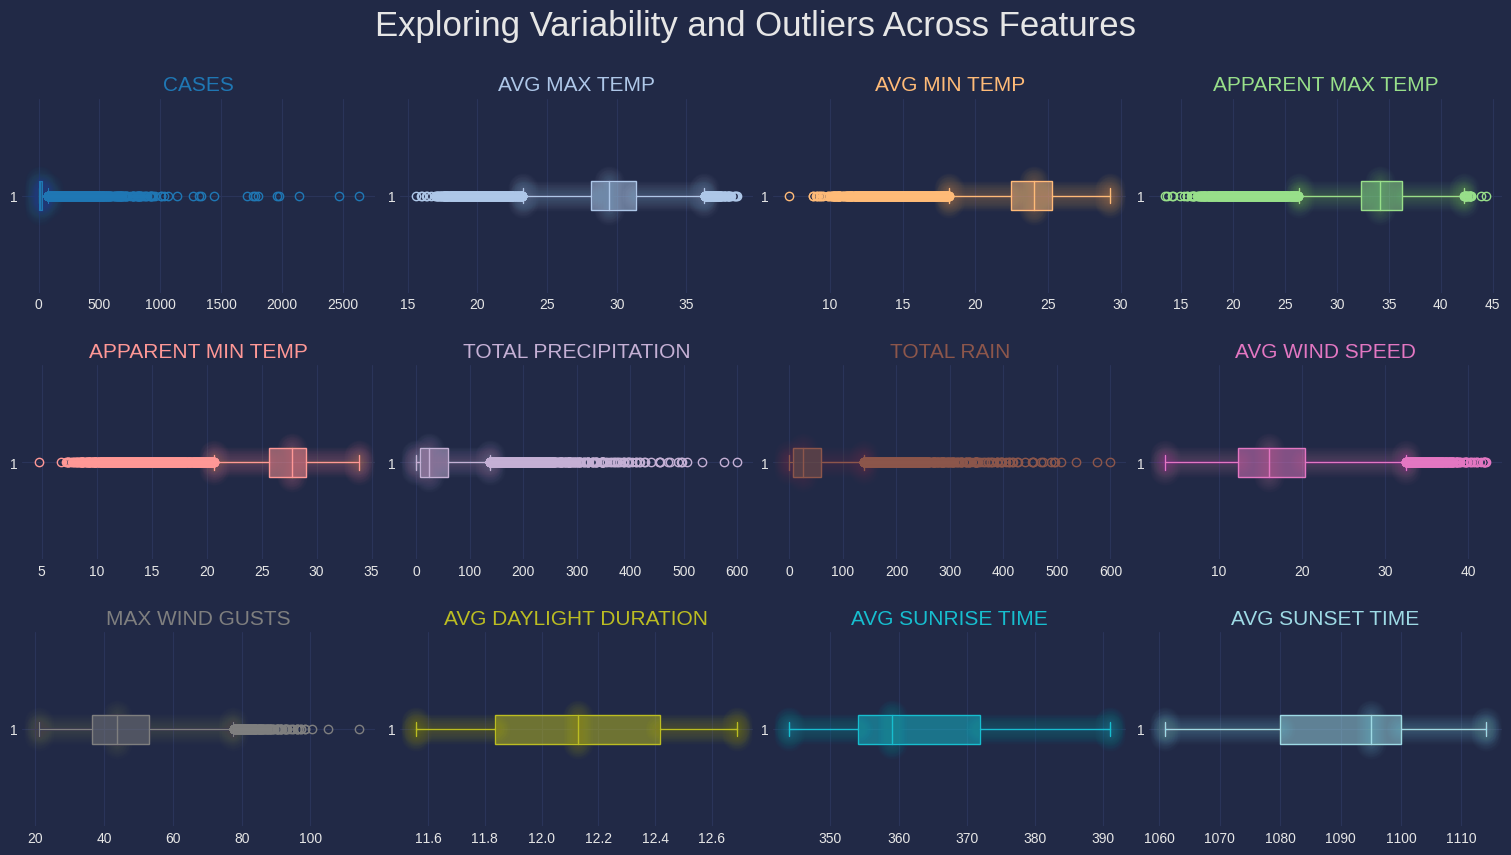

In [ ]:

dist_cols = dengue_cases_weather.drop(['District','Week_Start_Date','Month','Year','Week_End_Date','Weather Code','Week'], axis=1).columns
boxplots(dengue_cases_weather, dist_cols, "Exploring Variability and Outliers Across Features", 3, 4)

#### Visualizing Feature Distribution with KDE:
- `Dengue Cases:`Most data points show low case counts, but there's a clear tail representing significant outbreaks. This suggests that dengue cases spike during certain periods, possibly following heavy rainfall or extreme weather conditions.

----------------------------------------------

##### Summary for KDE & BOX plots:
- Dengue case surges are rare but significant, likely influenced by environmental factors such as heavy rainfall and stable tropical temperatures.
- Heavy rain events (even though rare) appear as key contributors to outbreaks by creating standing water for mosquito breeding.
- Temperature stability (both actual and perceived) promotes mosquito activity throughout the year, aligning with consistent dengue case numbers.
- Wind and daylight patterns remain stable and predictable, with minimal impact on outbreak timing but still relevant to mosquito ecology.

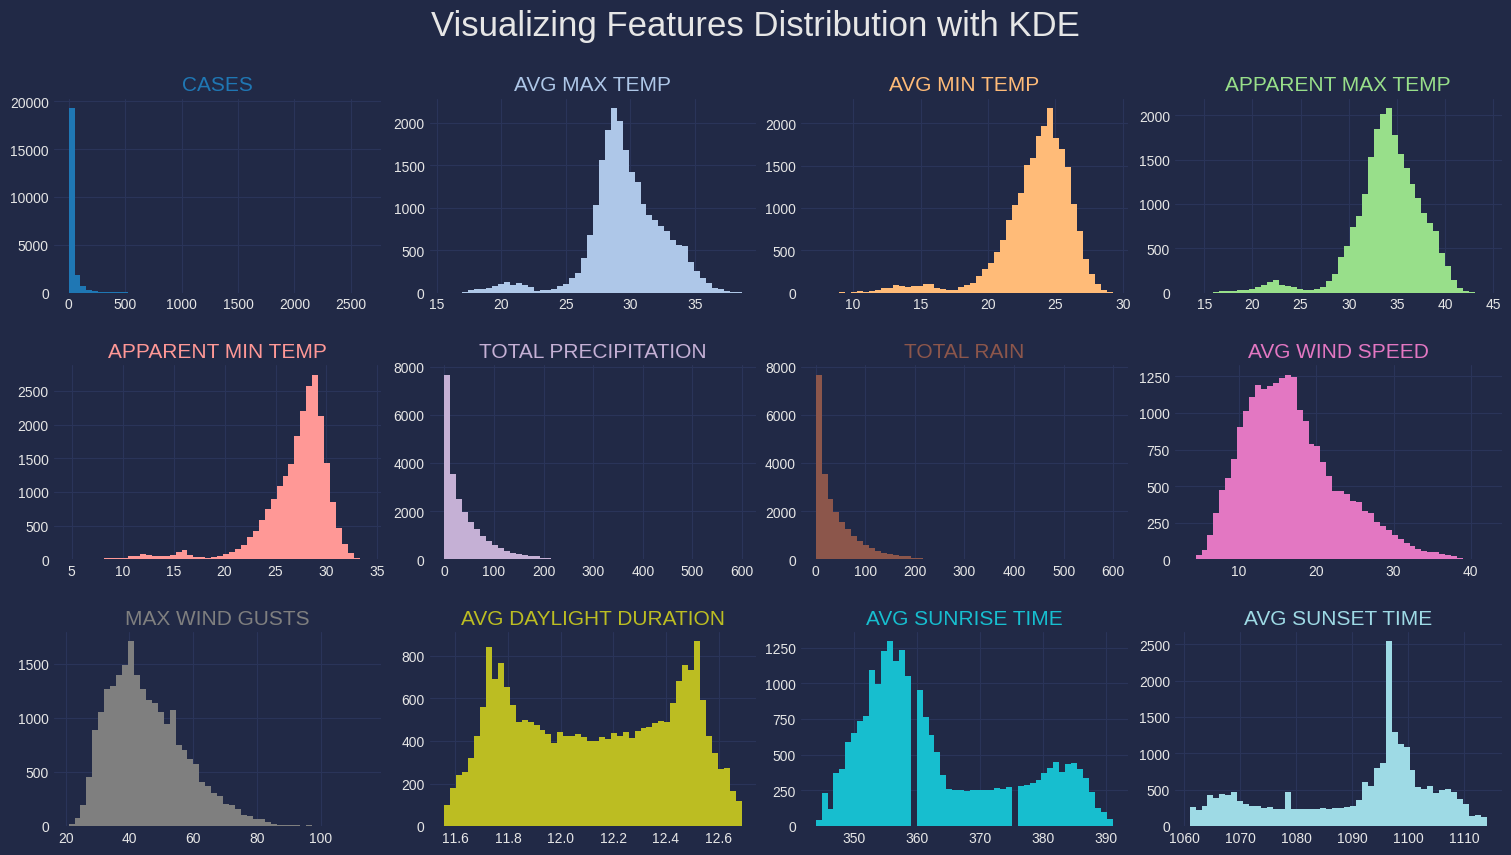

In [ ]:
histplots(dengue_cases_weather, dist_cols, "Visualizing Features Distribution with KDE", 3, 4)

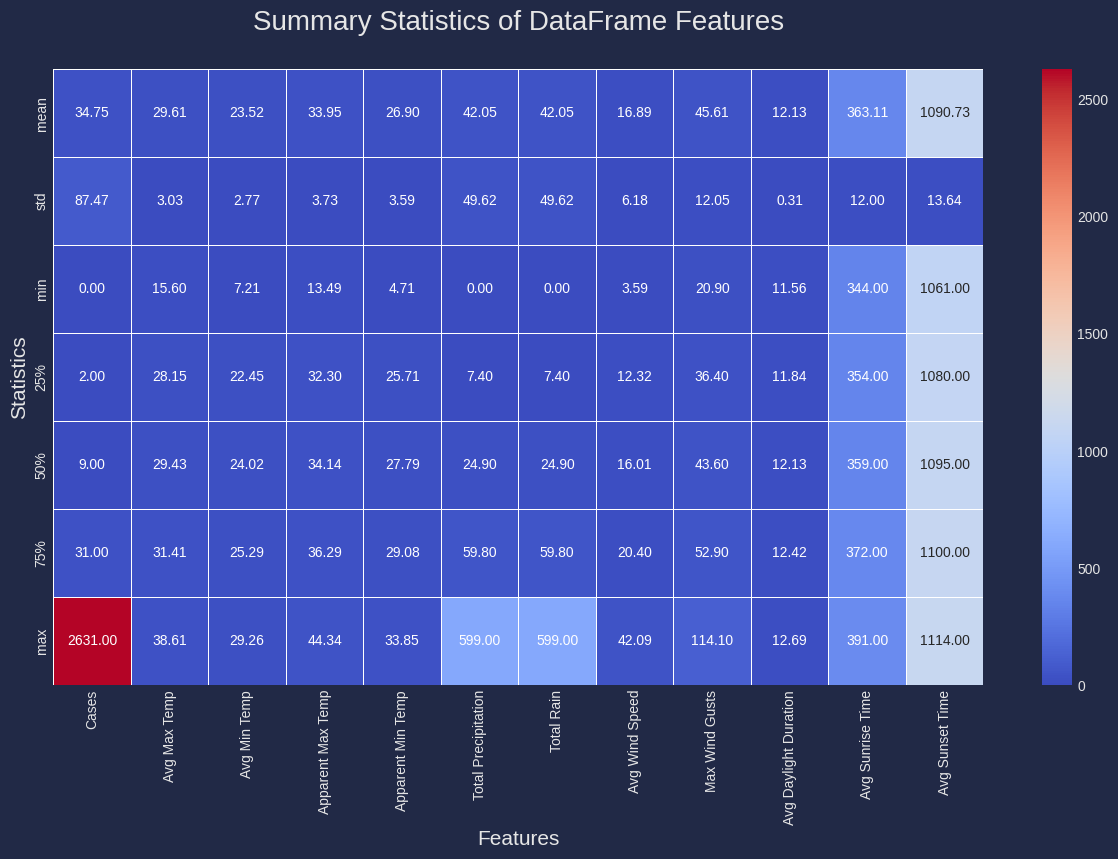

In [ ]:
describeplot(dengue_cases_weather, dist_cols, 'Summary Statistics of DataFrame Features')

In [ ]:
dengue_cases_weather.drop('Total Precipitation', axis = 1 , inplace = True)

### Create a mapper for the weather codes in Sri Lanka based on the following table, using WMO Weather Interpretation Codes (WW)
| Code | Description |
|-------------|-------------|
| `0` | Clear sky |
| `1, 2, 3` | Mainly clear, partly cloudy, and overcast |
| `45, 48` | Fog and depositing rime fog |
| `51, 53, 55`| Drizzle: Light, moderate, and dense intensity |
| `56, 57` | Freezing Drizzle: Light and dense intensity |
| `61, 63, 65` | Rain: Slight, moderate and heavy intensity |
| `66, 67` | Freezing Rain: Light and heavy intensity |
| `71, 73, 75` | Snow fall: Slight, moderate, and heavy intensity |
| `77` | Snow grains |
| `80, 81, 82` | Rain showers: Slight, moderate, and violent |
| `85, 86` | Snow showers slight and heavy|
| `95 *` | Thunderstorm: Slight or moderate |
| `96, 99 *` | Thunderstorm with slight and heavy hail |

(*) Thunderstorm forecast with hail is only available in Central Europe

In [ ]:
code_mapper = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    51: "Light drizzle",
    53: "Moderate drizzle",
    55: "Dense drizzle",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain"
}
dengue_cases_weather['Weather Code'] = dengue_cases_weather['Weather Code'].map(code_mapper)

#### The `Weather Code` shows variability in conditions, with light drizzle being the most common category in the data.

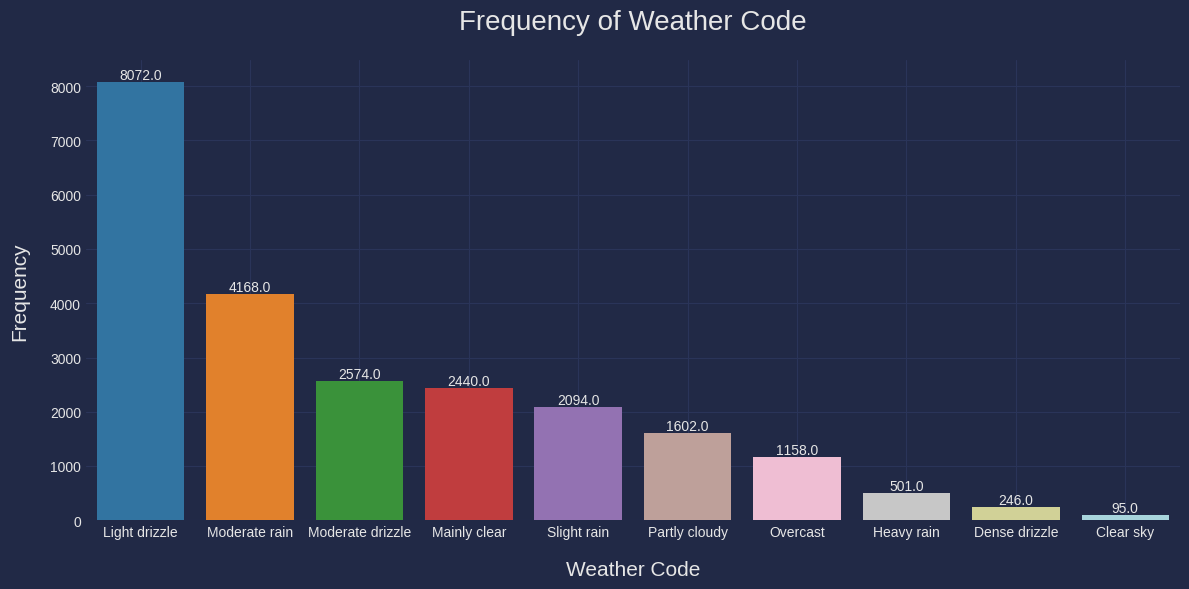

In [ ]:
num_colors = len(dengue_cases_weather['Weather Code'].unique())
cmap = cm.get_cmap('tab20', num_colors)
colors = [cmap(i) for i in range(num_colors)]

plt.figure(figsize=(12, 6))
ax=sns.countplot(data = dengue_cases_weather, x= "Weather Code",order= dengue_cases_weather['Weather Code'].value_counts().index, palette=colors[:len(dengue_cases_weather['Weather Code'].unique())])
ax.set_title("Frequency of Weather Code", fontsize=20,y=1.05)
ax.set_xlabel("Weather Code", labelpad =15, fontsize=15)
ax.set_ylabel("Frequency", labelpad =15, fontsize=15)
for i, patch in enumerate(ax.patches):
    x = patch.get_x()
    y = patch.get_y()
    width = patch.get_width()
    height = patch.get_height()
    center_x = x + width / 2
    top_y = y + height
    ax.text(center_x, top_y + 0.01, round(height, 2),
            ha='center', va='bottom', fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
ax.grid(color='#2A3459')

plt.show()

#### Make the following adjustments:
- Create a month mapper to make the visualization of the months more readable.
- Convert the format of `Avg Sunrise Time` and `Avg Sunset Time` from minutes back to the original time format.



In [ ]:
month_mapper = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

dengue_cases_weather['Month'] = dengue_cases_weather['Month'].map(month_mapper)

In [ ]:
print("Avg Sunrise Time range:", dengue_cases_weather['Avg Sunrise Time'].min(), "to", dengue_cases_weather['Avg Sunrise Time'].max())
print("Avg Sunset Time range:", dengue_cases_weather['Avg Sunset Time'].min(), "to", dengue_cases_weather['Avg Sunset Time'].max())

Avg Sunrise Time range: 344 to 391
Avg Sunset Time range: 1061 to 1114


In [ ]:
def minutes_to_time(minutes):
    hours, mins = divmod(minutes, 60)
    return f"{hours:02d}:{mins:02d}"

dengue_cases_weather['Sunrise_Time'] = dengue_cases_weather['Avg Sunrise Time'].apply(minutes_to_time)
dengue_cases_weather['Sunset_Time'] = dengue_cases_weather['Avg Sunset Time'].apply(minutes_to_time)

In [ ]:
dengue_cases_weather.head()

,District,Cases,Week_Start_Date,Month,Year,Week,Week_End_Date,Avg Max Temp,Avg Min Temp,Apparent Max Temp,Apparent Min Temp,Total Rain,Avg Wind Speed,Max Wind Gusts,Weather Code,Avg Daylight Duration,Avg Sunrise Time,Avg Sunset Time,Sunrise_Time,Sunset_Time
0,Ampara,0,2007-01-01,Jan,2007,1,2007-01-08,26.9375,21.8625,28.8500,24.1000,8.0,18.2000,44.3,Overcast,11.714583,376,1079,06:16,17:59
1,Ampara,0,2007-01-08,Jan,2007,2,2007-01-15,26.3500,23.3250,30.2625,26.7000,86.1,17.0250,43.6,Moderate drizzle,11.733333,378,1082,06:18,18:02
2,Ampara,0,2007-01-15,Jan,2007,3,2007-01-22,27.2125,23.1625,29.5750,25.9625,3.1,20.1875,48.2,Light drizzle,11.754167,380,1085,06:20,18:05
3,Ampara,0,2007-01-22,Jan,2007,4,2007-01-29,26.7250,23.0375,29.9500,26.1125,53.6,17.2000,42.5,Slight rain,11.783333,381,1088,06:21,18:08
4,Ampara,0,2007-01-29,Jan,2007,5,2007-02-05,27.3625,22.9625,30.7500,26.1250,8.2,17.2625,40.0,Light drizzle,11.812500,382,1090,06:22,18:10


#### Create an overview dashboard of the data and found the following:
- Total cases from 2007 to 2024: 797,493
- `Colombo` has the highest number of cases: 180,110
- July has the peak number of cases: 116,514
- There are nonlinear relationships between weather factors and the number of dengue cases.
- The peak number of cases occurs in the temperature range between 25°C and 35°C.


In [ ]:
districts_cases = dengue_cases_weather.groupby("District")['Cases'].apply(lambda x : x.sum()).reset_index().sort_values(by = "Cases", ascending = False)
most_district_cases = districts_cases.iloc[0]

month_cases =  dengue_cases_weather.groupby("Month")['Cases'].apply(lambda x : x.sum()).reset_index().sort_values(by = "Cases", ascending = False)
peakMonth_cases = month_cases.iloc[0]

total_cases  = dengue_cases_weather['Cases'].sum()
total_districts = len(dengue_cases_weather['District'].unique())


rainfall_data = dengue_cases_weather.groupby('Year')['Total Rain'].sum().reset_index()



#### Overview:
- Total number of dengue cases: 797,493
- Total number of districts: 25
- District with peak number of dengue cases: Colombo (180,110)
- Month with peak number of dengue cases: July (116,514)

----------------------------------
##### Key Insights:
1. `Correlation between Dengue Cases and Weather Factors:`
    -  Strong correlation between dengue cases and rainfall (+0.61), average temperatures (min & max), and wind speed (positive correlation, but less significant).
2. `Monthly Dengue Cases:`
    - July and June see the highest total dengue cases, with a sharp peak in July, suggesting seasonal patterns likely tied to monsoon rains.
3. `Dengue Cases by District:`
    - Colombo has the highest total number of cases, followed by Gampaha and Kandy, indicating urban centers are more affected.
4. `Dengue Cases vs. Avg Temperature:`
    - As temperatures rise, dengue cases remain high, with higher temperatures (30-35°C) aligning with higher case counts.
5. `Dengue Cases vs. Wind Speed:`
    - Wind speed shows some variation but doesn’t strongly affect dengue case numbers, though higher wind gusts slightly coincide with lower cases.
6. `Rainfall Trends:`
    - Heavy rainfall events in July, June, and November show a close link to higher dengue outbreaks, reinforcing that rainwater accumulation is a key factor in mosquito breeding and dengue transmission.

----------------------------------------------

##### Summary:
- Dengue cases in Sri Lanka spike during rainy seasons, with Colombo and July showing the most significant impact.
- Temperature and rainfall are critical environmental factors contributing to these outbreaks, while wind speed plays a minor role.

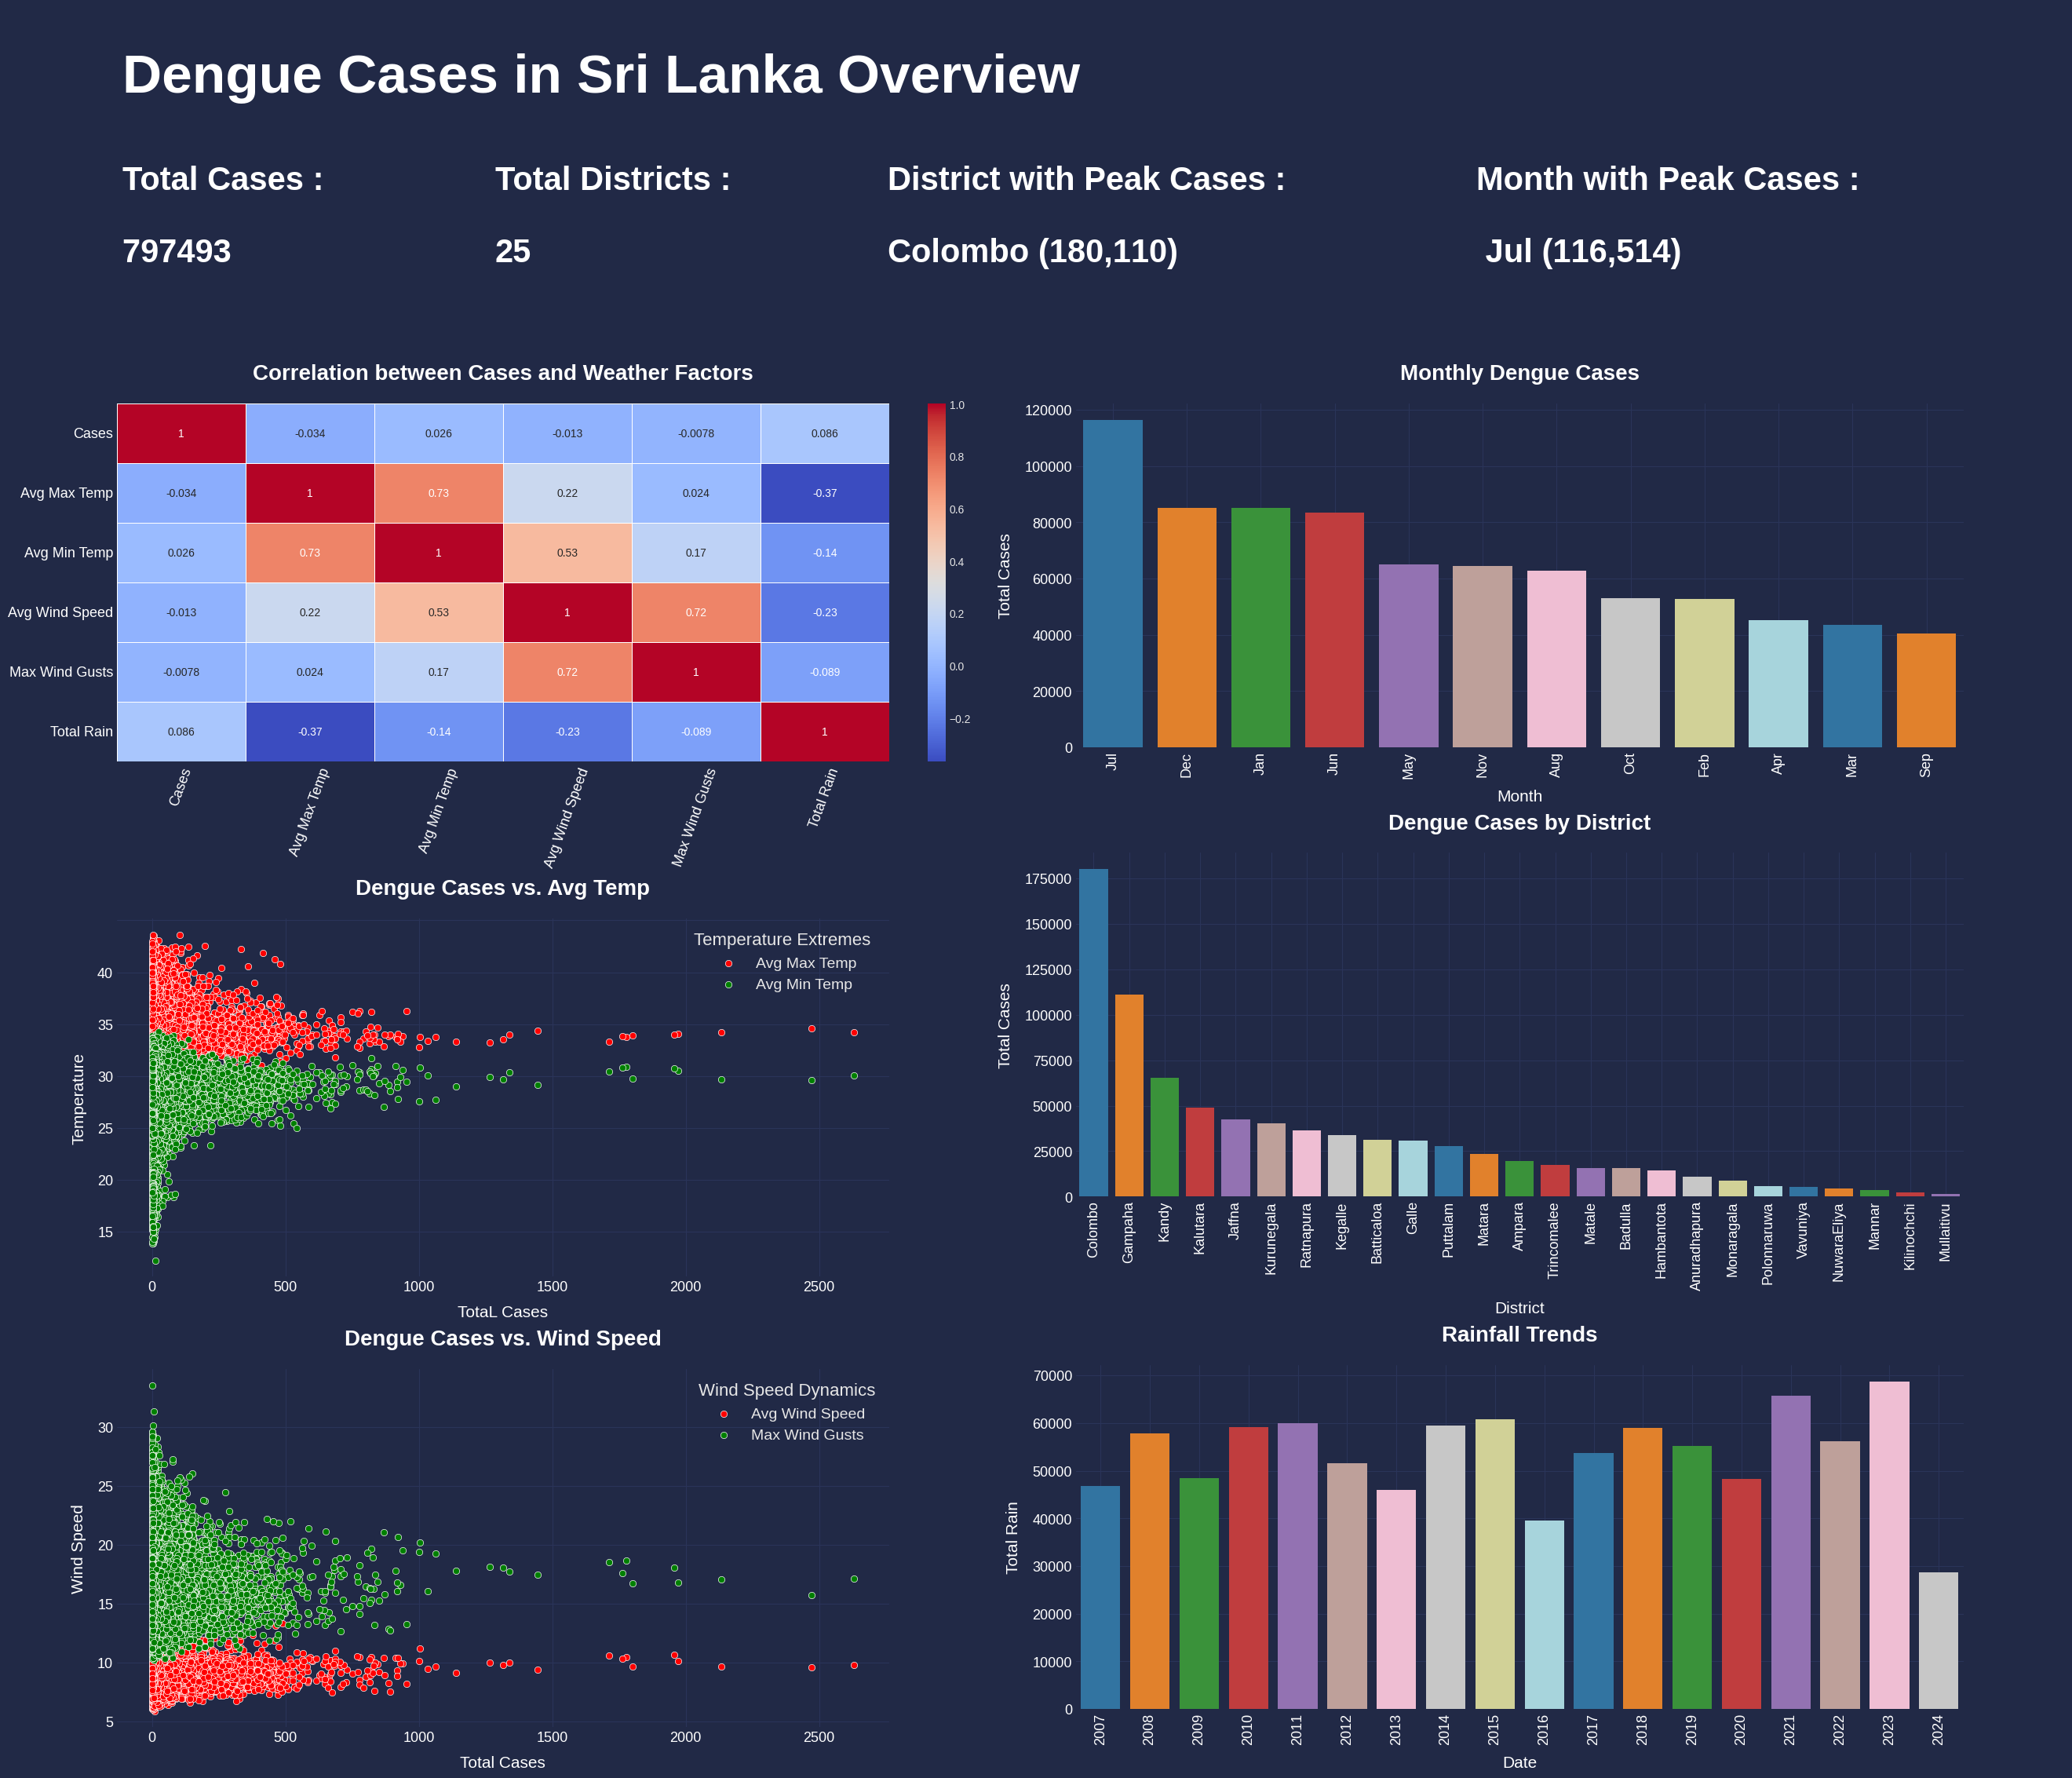

In [ ]:
fig = plt.figure(layout="constrained",figsize=(25,18))
fig.set_facecolor("#212946")

subfigs = fig.subfigures(1,2,zorder=-1)
subfigs[0].set_facecolor("#212946")
subfigs[1].set_facecolor("#212946")
Header = fig.add_axes((0.05,0.95,1,0.3))
Header.axis("off")
Header.text(0.01,0.8,f"Dengue Cases in Sri Lanka Overview",fontsize=50,color="white",fontweight='bold')
Header.text(0.01,0.4,f"Total Cases :               \n\n{ total_cases } ",fontsize=30,color="white",fontweight='bold')
Header.text(0.20,0.4,f"Total Districts :               \n\n{ total_districts}",fontsize=30,color="white",fontweight='bold')
Header.text(0.40,0.4,f"District with Peak Cases : \n\n{most_district_cases['District']} ({most_district_cases['Cases']:,})",fontsize=30,color="white",fontweight='bold')
Header.text(0.70,0.4,f"Month with Peak Cases : \n\n {peakMonth_cases['Month']} ({peakMonth_cases['Cases']:,})",fontsize=30,color="white",fontweight='bold')

subfigs1 = subfigs[0].subplots(3, 1)

corr_matrix = dengue_cases_weather[['Cases', 'Avg Max Temp', 'Avg Min Temp', 'Avg Wind Speed', 'Max Wind Gusts', 'Total Rain']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax = subfigs1[0], linewidths= 0.5)
subfigs1[0].set_title("Correlation between Cases and Weather Factors", fontsize=20, y=1.05, color="white",fontweight='bold')
subfigs1[0].set_xticklabels(subfigs1[0].get_xticklabels(), color="white", fontsize=13, rotation = 70)
subfigs1[0].set_yticklabels(subfigs1[0].get_yticklabels(), color="white", fontsize=13)

scatter_plot(dengue_cases_weather,'Cases','Avg Max Temp',subfigs1[1],'red','Total Cases','Temperature','Dengue Cases vs. Avg Temp', 'Avg Max Temp')
scatter_plot(dengue_cases_weather,'Cases','Avg Min Temp',subfigs1[1],'green','TotaL Cases','Temperature','Dengue Cases vs. Avg Temp', 'Avg Min Temp')
subfigs1[1].legend(title='Temperature Extremes ', fontsize =14, title_fontsize = 16)

scatter_plot(dengue_cases_weather,'Cases','Avg Wind Speed',subfigs1[2],'red','Total Cases','Wind Speed','Dengue Cases vs. Wind Speed', 'Avg Wind Speed')
scatter_plot(dengue_cases_weather,'Cases','Max Wind Gusts',subfigs1[2],'green','Total Cases','Wind Speed','Dengue Cases vs. Wind Speed', 'Max Wind Gusts')
subfigs1[2].legend(title='Wind Speed Dynamics', fontsize =14, title_fontsize = 16)

subfigs2 = subfigs[1].subplots(3, 1)

bar_plot(month_cases,'Month','Cases',subfigs2[0],'Month','Total Cases','Monthly Dengue Cases', 12)

bar_plot(districts_cases,'District','Cases',subfigs2[1],'District','Total Cases','Dengue Cases by District', 25)

bar_plot(rainfall_data,'Year','Total Rain',subfigs2[2],'Date','Total Rain','Rainfall Trends', len(dengue_cases_weather['Year'].unique()))


plt.show()


In [ ]:
pivot_month_daylight = dengue_cases_weather.pivot_table(values='Cases',
                             index='Month',
                             columns=pd.cut(dengue_cases_weather['Avg Daylight Duration'], bins=5),
                             aggfunc='mean')
pivot_dist_weather = dengue_cases_weather.pivot_table(values= 'Cases',
                              index = 'District',
                              columns = 'Weather Code',
                              aggfunc='mean')

pivot_year_temp = dengue_cases_weather.pivot_table(values = 'Cases',
                                                   index = 'Year',
                                                   columns = pd.cut(dengue_cases_weather['Avg Max Temp'], bins=5),
                                                   aggfunc='mean')
bins = [0, 120, 240, 360, 480, 600]
labels = ['(0, 120]', '(120, 240]', '(240, 360]', '(360, 480]', '(480, 600]']
pivot_month_rainfall = dengue_cases_weather.pivot_table(values = 'Cases',
                                                        index = 'Month',
                                                        columns = pd.cut(dengue_cases_weather['Total Rain'],bins=bins, labels = labels),
                                                        aggfunc='mean')
pivot_month_wind = dengue_cases_weather.pivot_table(values = 'Cases',
                                                        index = 'Month',
                                                        columns = pd.cut(dengue_cases_weather['Avg Wind Speed'], bins=5),
                                                        aggfunc='mean')

pivot_weather_rainfall =  dengue_cases_weather.pivot_table(values = 'Cases',
                                                        index = 'Weather Code',
                                                        columns = pd.cut(dengue_cases_weather['Total Rain'],bins=bins, labels = labels),
                                                        aggfunc='mean')

#### Average Dengue Cases by Month and Daylight Hours, Key Insights:
1. `Peak Dengue Cases in Jyly:`
    - July has the highest number of dengue cases, peaking at 79.94 cases with 51.05 cases corresponding to longer daylight hours (12.236 - 12.462). This suggests a strong link between high case numbers and extended daylight during the monsoon season.
2. `High Cases in December and January:`
    - December (45.68 cases) and January (42.40 cases) show elevated dengue activity, likely due to post-monsoon effects, despite shorter daylight hours in the 11.557 - 11.784 range.
3. `Moderate Cases in June:`
    - June shows a noticeable rise in dengue cases (31.11 cases) aligning with longer daylight hours (12.236 - 12.462), indicating that cases start climbing before the July peak.
4. `Lower Cases in Early Months (March, April):`
    - March and April have relatively fewer cases (13.35 and 31.14 cases, respectively), even with moderate daylight hours. This reflects a pre-monsoon period with lower mosquito activity.
5. `Cases Trends Across Daylight Hours:`
    - Longer daylight hours generally align with higher dengue cases, especially during the monsoon and post-monsoon periods (July, June, December). Shorter daylight months like March and September see fewer cases, showing less favorable conditions for mosquito breeding.

----------------------------------------------

##### Summary:
- Dengue cases peak in July with longer daylight hours, indicating that extended sunlight and post-rainfall conditions create ideal breeding grounds for mosquitoes.
- The late-year surge in December and January, even with shorter daylight, suggests residual effects of monsoon rains.
- Shorter daylight months like March and April see fewer cases, reflecting less conducive conditions for dengue transmission.

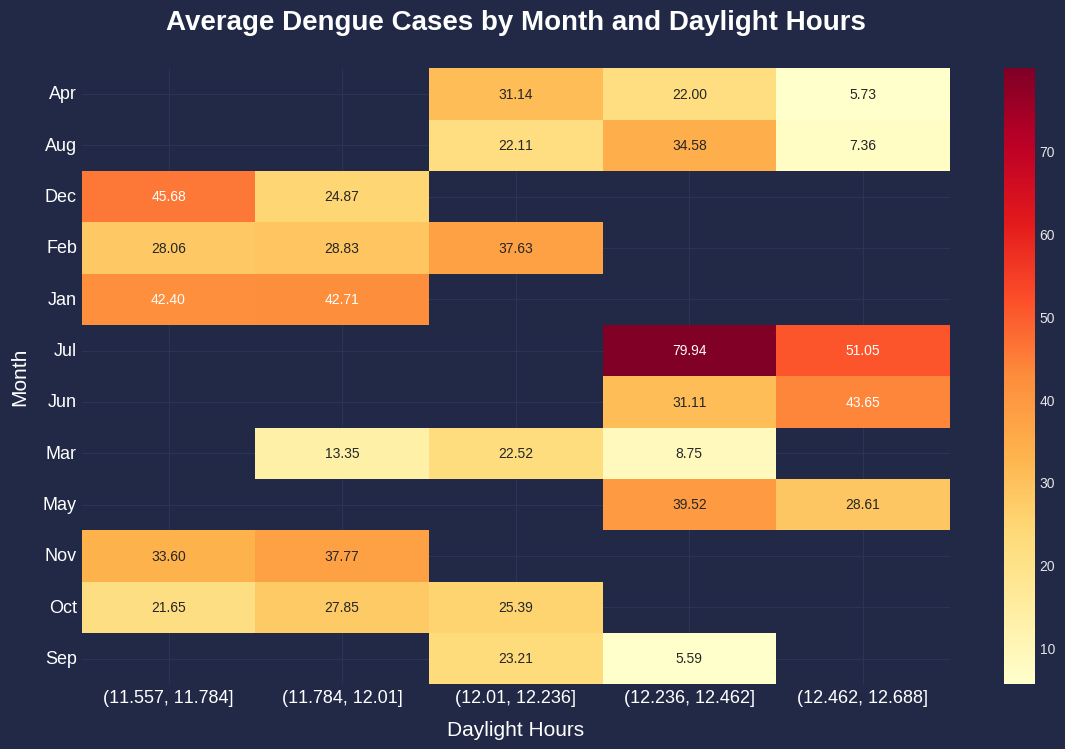

In [ ]:
fig , ax = plt.subplots(figsize=(14, 8))

pivot_plot (pivot_month_daylight, 'Average Dengue Cases by Month and Daylight Hours','Daylight Hours','Month', ax)

plt.show()


#### Average Dengue Cases by District and Weather code, Key Insights:
1. `Colombo and Gampaha Hotspots:`
    - Colombo and Gampaha have the highest dengue cases across all weather conditions, with peaks under Heavy Rain (Colombo: 277.24 cases, Gampaha: 210.53 cases) and Moderate Rain. These urban centers are clearly the most affected, likely due to higher population density and urban breeding conditions.
2. `Weather Impact:`
    - Heavy Rain and Moderate Rain consistently show the highest dengue case counts across most districts, emphasizing the direct influence of rainfall on mosquito breeding and dengue outbreaks.
    - Clear Sky and Partly Cloudy weather lead to significantly fewer cases, as dry conditions hinder mosquito breeding.
3. `Moderate Cases in Other Districts:`
    - Kandy, Kegalle, and Kurunegala also show elevated cases, particularly during Moderate Rain and Heavy Rain, although not as extreme as Colombo and Gampaha.
    - Coastal districts like Galle and Batticaloa see moderate dengue cases, especially during wet weather conditions, highlighting the role of geography and weather in dengue transmission.
4. `Low-Dengue Districts:`
    - Districts like Mullaitivu, Nuwara Eliya, and Vavuniya have minimal dengue cases across all weather codes, possibly due to lower mosquito activity or better environmental conditions that do not favor dengue transmission.

----------------------------------------------

##### Summary:
- Heavy and Moderate Rain have the most significant impact on dengue outbreaks, with Colombo and Gampaha being the most affected districts. Rainfall creates ideal conditions for mosquito breeding, directly correlating with dengue case surges.
- Clear skies and partly cloudy conditions reduce dengue risk, as they limit standing water sources needed for mosquito breeding.
- While urban centers face the highest dengue threats, rural districts experience moderate cases, especially during the rainy season.

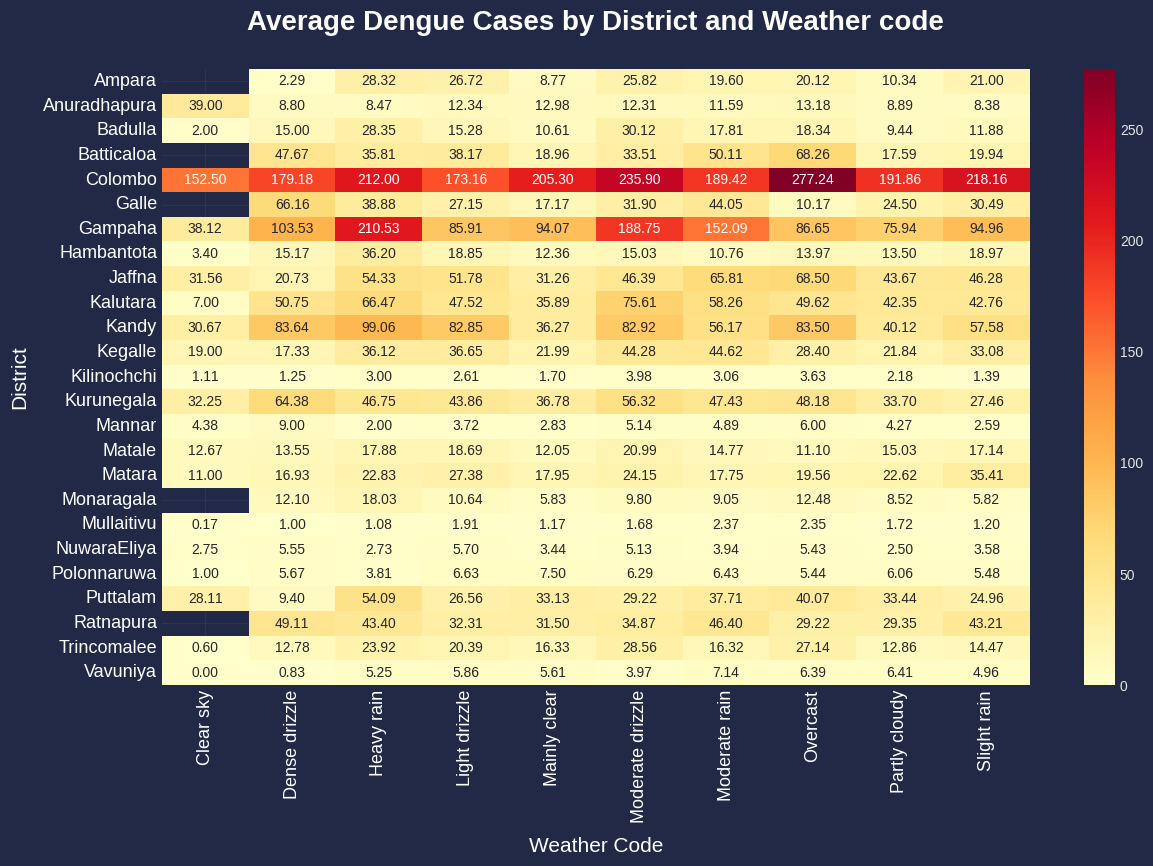

In [ ]:

fig , ax = plt.subplots(figsize=(14, 8))

pivot_plot (pivot_dist_weather, 'Average Dengue Cases by District and Weather code','Weather Code','District', ax)

plt.show()

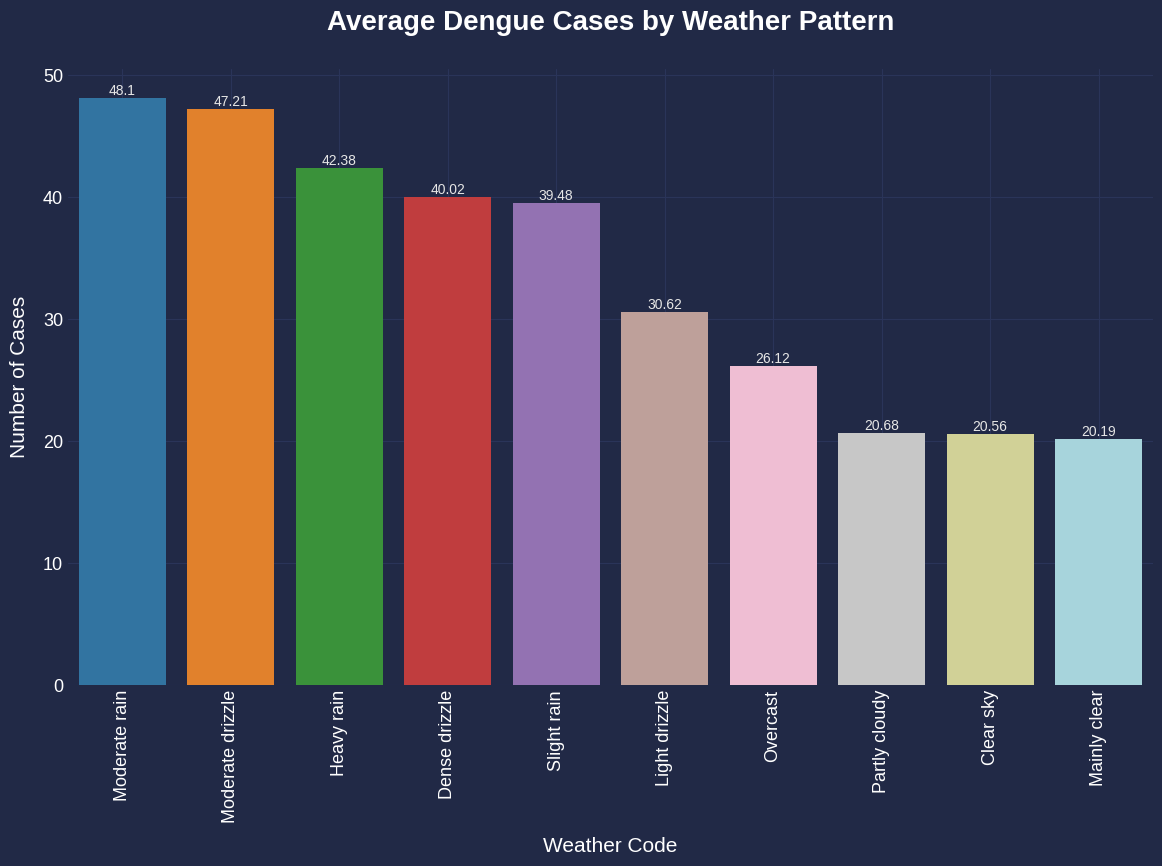

In [ ]:
weather_pattern_cases = dengue_cases_weather.groupby('Weather Code')['Cases'].mean().reset_index().sort_values(by = "Cases", ascending = False)
fig , ax = plt.subplots(figsize=(14, 8))

bar_plot(weather_pattern_cases,'Weather Code','Cases',ax,'Weather Code','Number of Cases','Average Dengue Cases by Weather Pattern', 10)
for i, patch in enumerate(ax.patches):
    x = patch.get_x()
    y = patch.get_y()
    width = patch.get_width()
    height = patch.get_height()
    center_x = x + width / 2
    top_y = y + height
    ax.text(center_x, top_y + 0.01, round(height, 2),
            ha='center', va='bottom', fontsize=10)
plt.show()

#### Average Dengue Cases by Year and Temperature, Key Insights:
1. `2017 Dengue Surge:`
    - The year 2017 witnessed the highest average dengue cases across all temperature ranges, peaking at 190.59 cases for the 24.805 - 29.408°C range. This is a standout year, likely due to a combination of factors such as extreme weather conditions, higher rainfall, or other environmental influences.
2. `2019 and 2022 Case Spikes:`
    - In 2019, there was another surge in cases (127.97) for temperatures between 24.805 - 29.408°C, similar to 2017 but less severe.
    - 2022 also saw elevated dengue activity, with 86.11 cases aligning with warmer temperatures, reflecting a recurrence of high transmission seasons.
3. `Temperature Impact:`
    - The 24.805 - 29.408°C range consistently shows the highest dengue cases across most years, indicating that these temperatures are optimal for mosquito breeding and dengue transmission.
    - Extremely high temperatures (above 34°C) seem to reduce dengue cases, possibly due to adverse conditions for mosquito survival or activity.
4. `Recent Decline (2021-2024):`
    - Starting from 2021, dengue cases have been lower compared to previous peak years, even though 2024 shows some increase. The decline could be attributed to better disease control measures or varying environmental factors.

----------------------------------------------

##### Summary:
- 2017 stands out as the year with the highest dengue cases, with temperatures in the 24.8 - 29.4°C range contributing most to outbreaks.
- Temperature range is a critical factor, as this optimal range appears to foster conditions that support mosquito breeding and dengue spread. Extremely high temperatures reduce case numbers.
- Recent years (2021-2024) show a general decline in cases, signaling potential improvements in managing dengue outbreaks or less favorable breeding conditions. However, 2024 shows a slight upward trend.

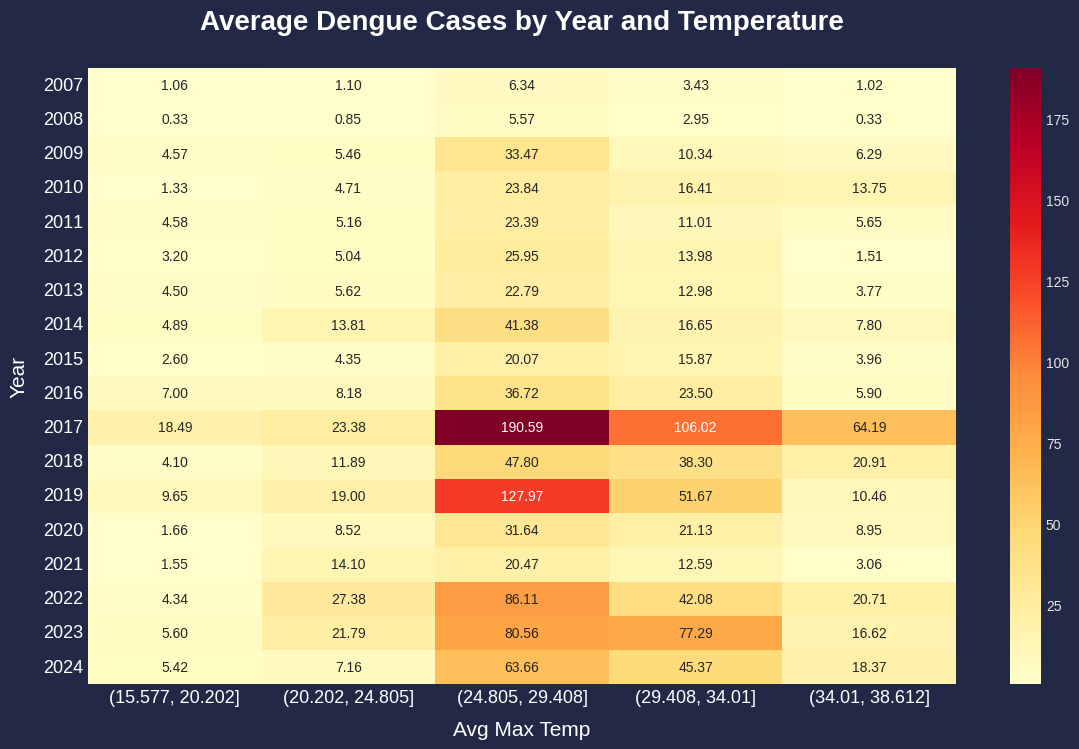

In [ ]:

fig , ax = plt.subplots(figsize=(14, 8))

pivot_plot (pivot_year_temp, 'Average Dengue Cases by Year and Temperature','Avg Max Temp','Year', ax)

plt.show()

#### Average Dengue Cases by Month and Rainfall, Key Insights:
1. `Peak Dengue Cases in June and July"`
    - July and June show the highest dengue case counts, with peaks of 132.20 and 139.65 cases respectively, corresponding to rainfall between 120-240 mm. This reflects the heavy monsoon rains during these months, which create ideal breeding conditions for mosquitoes.
2. `August Surge:`
    - August also sees elevated dengue cases (90.19 cases) in the same 120-240 mm rainfall range, highlighting a continuation of the monsoon effect into late summer.
3. `Moderate Cases in December and January:`
    - December and January show moderate dengue case activity, particularly when rainfall reaches 240-360 mm in December, with 38.60 cases. This suggests post-monsoon rains still contribute to mosquito breeding during the winter season.
4. `Low Cases with Minimal Rainfall:`
    - Months like March and April show significantly lower dengue cases across all rainfall ranges, as the lack of sufficient rain (below 120 mm) limits the creation of standing water for mosquitoes to breed.
5. `May and November Activity:`
    - May and November show moderate spikes in dengue cases, particularly in the 120-240 mm rainfall range. These months may experience transitional rains leading up to the heavier monsoon, facilitating moderate outbreaks.

----------------------------------------------

##### Summary:
- June and July represent the peak dengue season, driven by monsoon rains that provide ideal mosquito breeding conditions.
- Dengue cases are strongly correlated with rainfall levels between 120-240 mm, which coincides with the rainy season, while drier months like March and April show minimal case activity.
- December and January see lingering dengue cases due to post-monsoon rainfall, though at a lower intensity compared to mid-year peaks.

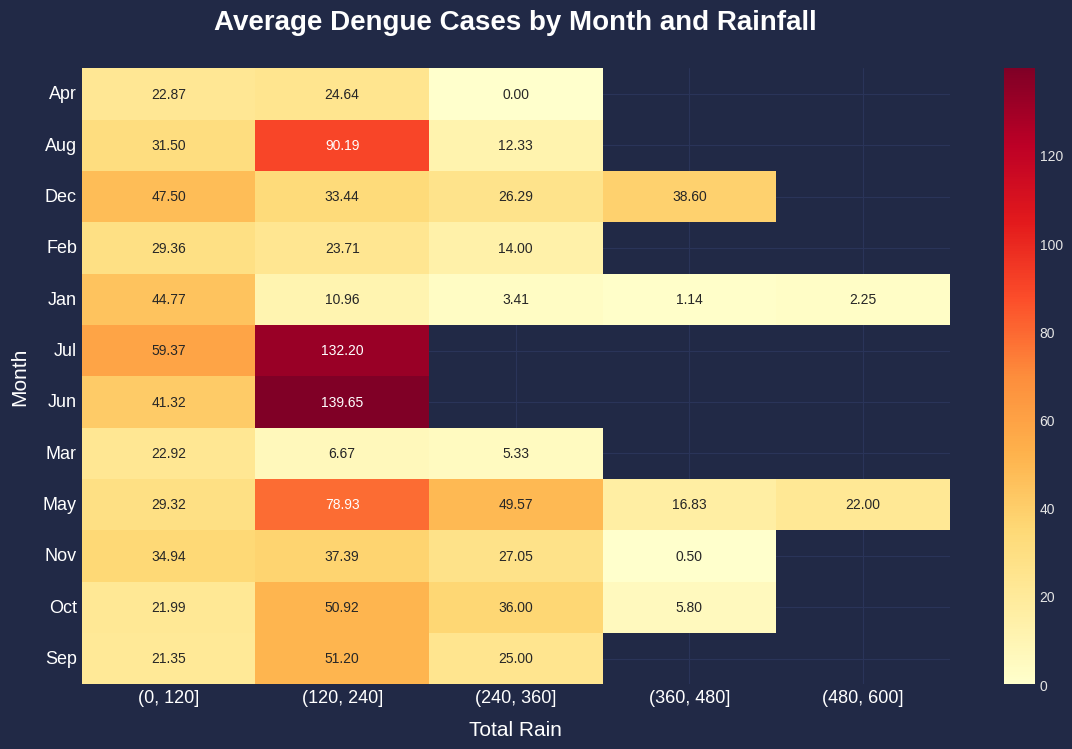

In [ ]:
fig , ax = plt.subplots(figsize=(14, 8))

pivot_plot (pivot_month_rainfall, 'Average Dengue Cases by Month and Rainfall','Total Rain','Month', ax)

plt.show()

#### Average Dengue Cases by Weather Code and Rainfall, Key Insights:
1. `Heavy Rain and Moderate Rain Drive Dengue Cases:`
    - Heavy rain and moderate rain consistently result in the highest average dengue cases, with peaks at 46.48 cases for heavy rain and 57.34 cases for moderate rain in the 120-240 mm rainfall range. This emphasizes the strong relationship between high rainfall and dengue outbreaks.
2. `Moderate Drizzle Impact:`
    - Moderate drizzle also contributes significantly to dengue cases, particularly with 47.52 cases in the 0-120 mm rainfall range, indicating that even lighter but consistent rainfall can create suitable mosquito breeding conditions.
3. `Decreased Cases with Clear Skies and Minimal Rain:`
    - Clear skies and mainly clear weather have notably fewer dengue cases, with 23.32 cases under clear skies and 20.85 cases under mainly clear conditions. This suggests that dry weather limits mosquito breeding and, consequently, dengue transmission.
4. `Low Dengue Cases with High Rainfall (480-600 mm):`
    - When rainfall exceeds 480 mm, dengue cases drop significantly, regardless of the weather code, suggesting that extreme rainfall may disrupt mosquito breeding or wash away breeding sites, reducing transmission.
5. `Drizzle and Light Rain’s Contribution:`
    - Dense drizzle and light drizzle also show moderate dengue cases, particularly in the 0-240 mm rainfall range, demonstrating that frequent light rain events can still maintain breeding grounds for mosquitoes.

----------------------------------------------

##### Summary:
- Moderate and heavy rains (120-240 mm range) are most closely associated with peak dengue cases, providing ideal conditions for mosquito breeding.
- Even drizzle (moderate and dense) can lead to significant dengue activity, while clear skies and low rainfall result in lower cases.
- Extremely high rainfall (480-600 mm) appears to reduce dengue cases, likely due to flooding or disruption of breeding sites.

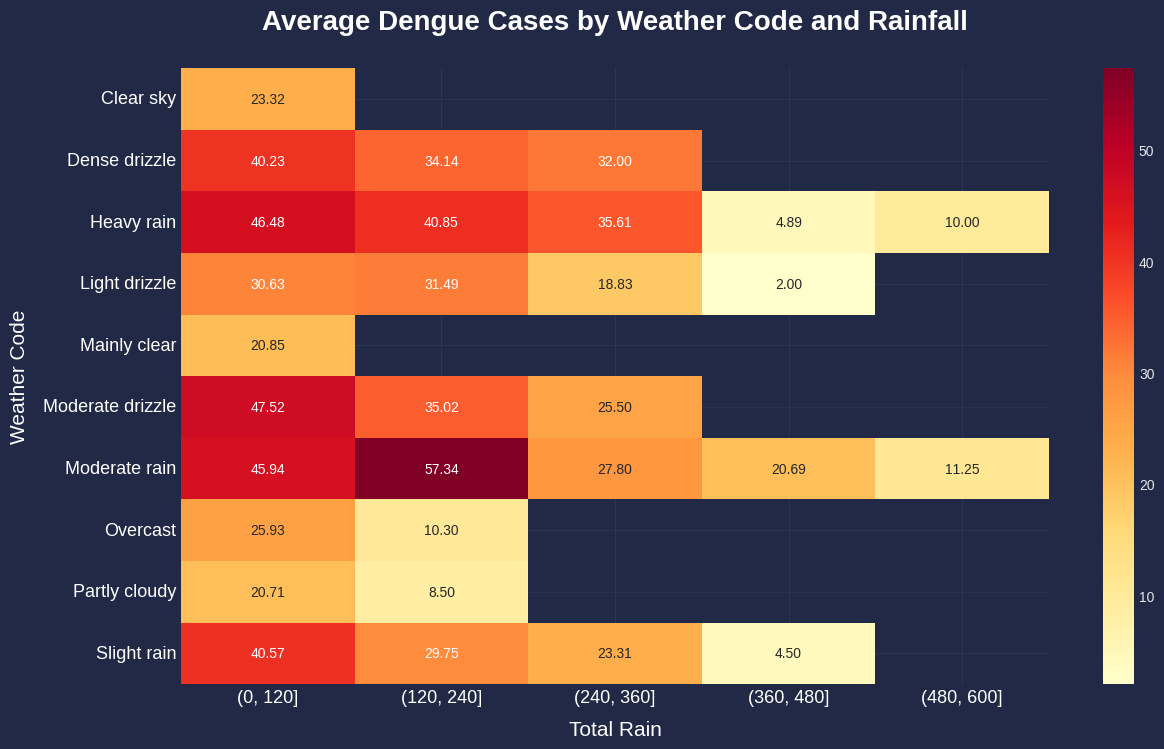

In [ ]:
fig , ax = plt.subplots(figsize=(14, 8))

pivot_plot (pivot_weather_rainfall, 'Average Dengue Cases by Weather Code and Rainfall','Total Rain','Weather Code', ax)

plt.show()

#### Average Dengue Cases by Month and Wind Speed, Key Insights:
1. `High Dengue Cases in July and June:`
    - July and June have the highest dengue cases, peaking at 72.49 and 61.33 cases, respectively, under moderate wind speeds (11.288 - 18.988 km/h). This suggests that moderate winds may not strongly affect mosquito populations, allowing outbreaks to persist during these months.
2. `August and December Spikes:`
    - August and December also show significant dengue cases, with 52.60 cases in December and 42.18 cases in August, again concentrated around moderate wind speeds (11.288 - 18.988 km/h). These months coincide with post-monsoon periods and favorable conditions for mosquito breeding.
3. `Dengue Cases Decline with Higher Wind Speeds:`
    - Across most months, high wind speeds (26.688 km/h and above) result in fewer dengue cases. For example, July sees a reduction from 72.49 cases at moderate wind speeds to 14.59 at higher speeds. This suggests that stronger winds may help disperse mosquitoes or reduce their activity.
4. `Low Cases in March and April:`
    - March and April experience low dengue activity, with less than 30 cases under all wind speeds, reflecting less favorable wind conditions for mosquito survival during these months.
5. `General Trends:`
    - Dengue cases tend to peak with moderate wind speeds (11.288 - 18.988 km/h) across most months, while both low and high wind speeds correlate with fewer dengue cases.

----------------------------------------------

##### Summary:
- July and June have the highest dengue cases, especially at moderate wind speeds, where mosquitoes are less affected by environmental conditions.
- High wind speeds seem to limit mosquito activity, reducing dengue transmission across most months.
- August and December also experience elevated dengue cases, likely due to post-monsoon conditions and moderate winds, while March and April see minimal activity due to less favorable weather conditions.

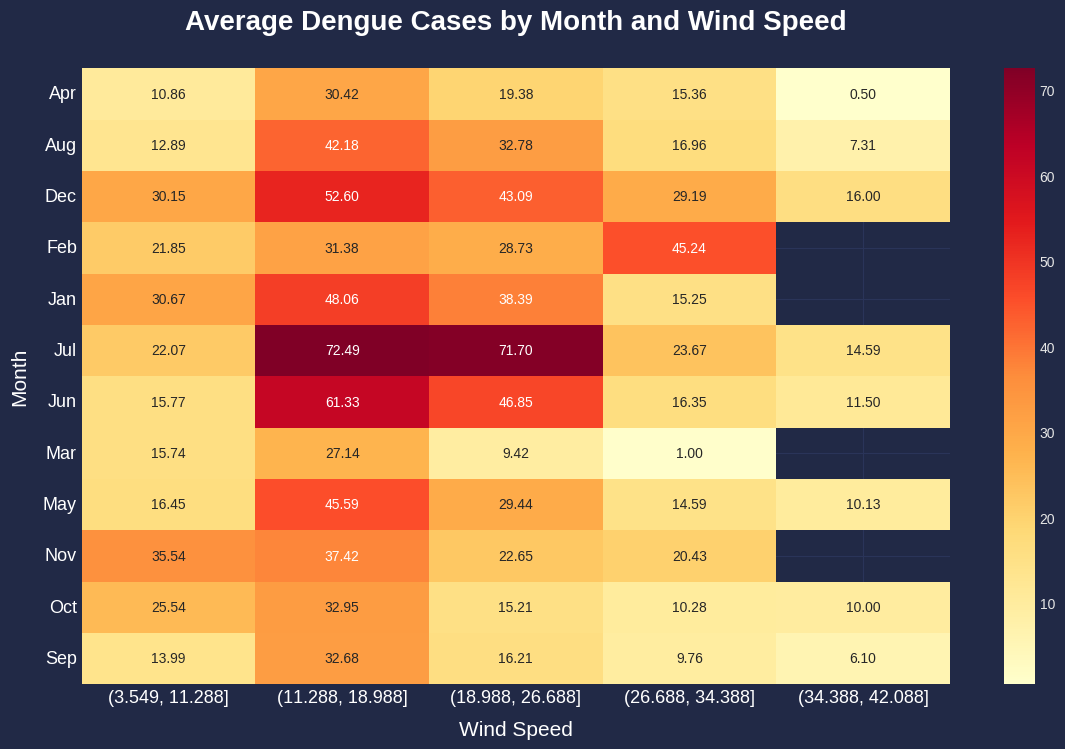

In [ ]:
fig , ax = plt.subplots(figsize=(14, 8))

pivot_plot (pivot_month_wind, 'Average Dengue Cases by Month and Wind Speed','Wind Speed','Month', ax)

plt.show()

#### Dengue Cases Decomposition, Key Insights:
1. `Overall Dengue Cases:`
    - The top plot shows the total dengue cases over time. There is a noticeable spike around 2017, with cases peaking near 10,000, followed by smaller but sustained peaks afterward. This reflects a major outbreak, followed by fluctuating but elevated dengue activity in the following years.
2. `Trend Component:`
    - The second plot illustrates the underlying trend of dengue cases. From 2008 to 2016, there is a steady but slight increase, followed by a sharp rise during the 2017 peak. The trend dips afterward but remains at an elevated level, indicating sustained higher case numbers post-2017 compared to earlier years.
3. `Seasonal Component:`
    - The third plot shows a clear seasonal pattern, with consistent peaks and troughs each year. This reflects the annual cycle of dengue transmission, which is likely linked to seasonal factors such as rainfall and temperature. The regularity of the peaks suggests predictable dengue seasons, with cases consistently rising and falling throughout the year.
4. `Residual Component:`
    - The bottom plot displays the residual (unexplained) component, highlighting deviations from the trend and seasonal patterns. There is a large spike around 2017, indicating anomalies during the outbreak that cannot be explained by the usual trend or seasonality. Subsequent years show smaller but noticeable variations, reflecting unpredictability in certain years.
  
----------------------------------------------

##### Summary:
- Dengue cases show a strong seasonal cycle, with predictable rises and falls each year. The 2017 outbreak caused a significant deviation from the usual pattern, and although cases decreased afterward, the overall trend remained higher than pre-2017 levels.
- Seasonal factors continue to drive yearly dengue cycles, but there are periods of unexplained variations (residuals), especially during the outbreak years.

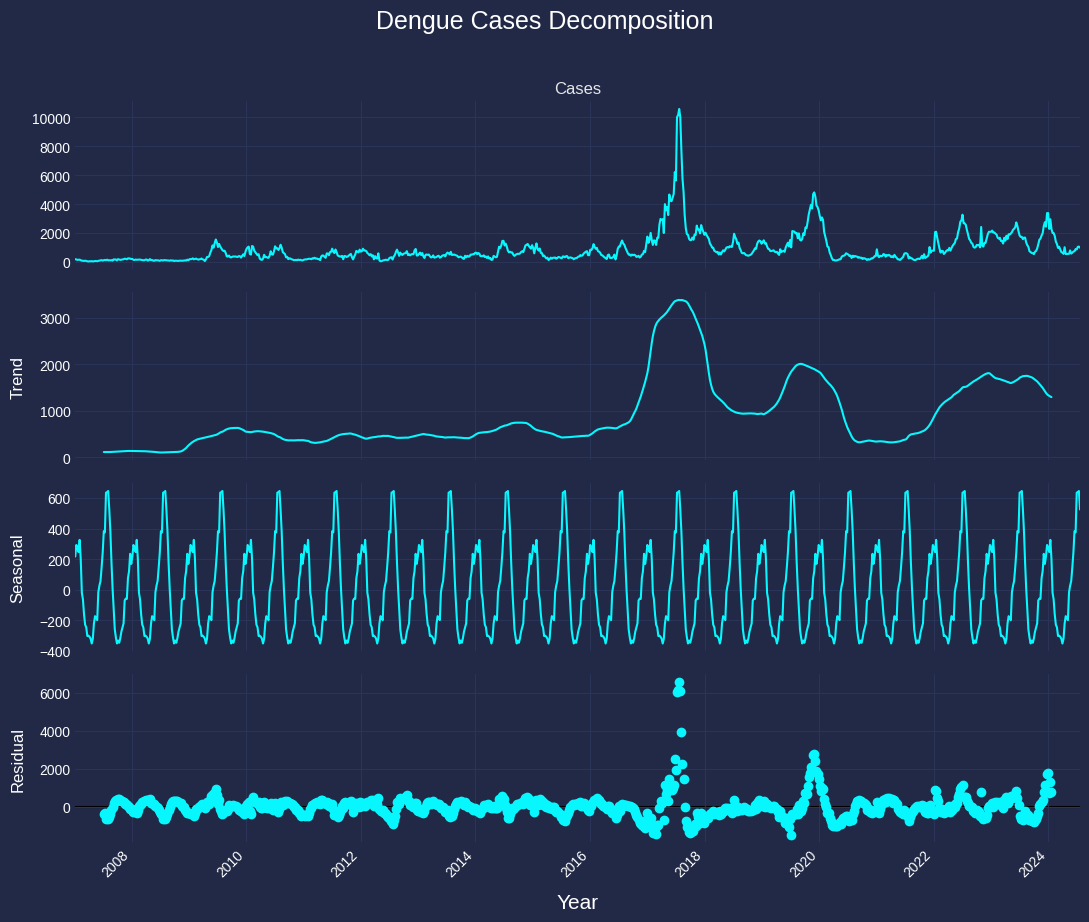

In [ ]:
weakly_pattern = dengue_cases_weather.set_index('Week_Start_Date')

weekly_cases = weakly_pattern['Cases'].resample('W').sum()
rcParams['figure.figsize']= 11,9

decomposition = seasonal_decompose(weekly_cases, model='additive', period=52)

fig = decomposition.plot()

fig.axes[1].set_ylabel('Trend', fontsize=12, labelpad=10, color="white")
fig.axes[2].set_ylabel('Seasonal', fontsize=12, labelpad=10, color="white")
fig.axes[3].set_ylabel('Residual', fontsize=12, labelpad=10, color="white")

fig.axes[-1].set_xlabel('Year', fontsize=15, labelpad=10, color="white")

fig.suptitle('Dengue Cases Decomposition', fontsize=18, color="white", y=1.02)

plt.subplots_adjust(top=0.9)

for ax in fig.axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10, color="white")
    plt.setp(ax.get_yticklabels(),fontsize=10, color="white")

plt.tight_layout()
plt.show()

In [ ]:
from dagshub.notebook import save_notebook

save_notebook(repo="Omdena/KegalleSriLankaChapter_PredictingDengueFeverOutbreaks",
              path="04_data_analysis",
              branch="feature/data-analysis",
               commit_message="""Added exploratory data analysis and storytelling for Dengue Fever Outbreaks in Sri Lanka.

    - Conducted a detailed EDA of outbreak data for all provinces.
    - Visualized trends over time using interactive charts.
    - Highlighted key insights related to environmental factors.""")


Uploading files (1) to "Omdena/KegalleSriLankaChapter_PredictingDengueFeverOutbreaks"...

Upload finished successfully!